In [30]:
import pandas as pd
import numpy as np
import scipy as sp

In [31]:
eperc = 1.602*10**-19

c = 2.996*10**8

h = 6.626*10**-34

hep = h/eperc

thermlim = 0.687


In [32]:
l =np.array([1,2,3,4])
#p = np.prod(l[1:3], 2)
p = l[1:3] * 2
print(p)

[4 6]


In [33]:
bands = [np.arange(3.5, 1.5, -.1), np.arange(2.5, 1, -.1), np.arange(1.5, .5, -.1)] 
combs = []
print(bands[0])

[3.5 3.4 3.3 3.2 3.1 3.  2.9 2.8 2.7 2.6 2.5 2.4 2.3 2.2 2.1 2.  1.9 1.8
 1.7 1.6]


In [34]:
def makes(inlist):
    olist = [[i] for i in inlist[0]]
    for k in inlist[len(olist[len(olist) - 1]):]:
        #for k in inlist[len(olist[0]):]:
        #for k in inlist[1:]:
        temp = []
        for j in olist: 
            for n in k:
                if j[len(j) - 1] > n:
                    temp.append(j + [n])
        #print(temp)
            olist = temp
        #print(olist)
    #print(olist)
    return olist



In [35]:
#photons = pd.read_excel('astmg173.xls', header = 1)

In [36]:
#photons.head()

In [37]:
#photons.columns

In [38]:
#photons['Direct+circumsolar W*m-2*nm-1'].max()

In [39]:
import csv
nano = []

with open('/home/harry/old_school_project/nanometers.csv') as csvfile:
        readCSV = csv.reader(csvfile, delimiter = ',')
        for row in readCSV:
                for i in row:
                        nano.append(float(i))


flux = []

with open('/home/harry/old_school_project/phoflux.csv') as csvfile:
        readCSV = csv.reader(csvfile, delimiter = ',')
        for row in readCSV:
                for i in row:
                        flux.append(float(i))
                        
flux = np.array(flux)
nano = np.array(nano)

In [40]:
nano

array([ 280. ,  280.5,  281. , ..., 3990. , 3995. , 4000. ])

In [41]:
flux

array([6.66835542e-05, 1.73780890e-03, 8.04817410e-03, ...,
       1.48078783e+17, 1.45000329e+17, 1.43053413e+17])

In [42]:
class layer:
    import bisect as bis
    import numpy as np
    import pandas as pd
    
    active = False
    
    eperc = 1.602*10**-19

    c = 2.996*10**8

    h = 6.626*10**-34

    hep = h/eperc

    thermlim = 0.687

    def __init__(self, depth, absorptance, reflectance):
        self.depth = depth
        self.absorptance = absorptance
        self.reflectance = reflectance
        #self.order = order

        
    def get_trans(self):
            self.transmittance = 1 - (self.absorptance + self.reflectance)
        
    def get_nums(self):
        return self.depth, self.absorptance, self.reflectance
    
    def light_thr(self, inlight):
        trans = (1 - (self.absorptance + self.reflectance)) * inlight
        return trans
        
    def interp(self, flar, nmar, w, t):
#This interpolates and estimates the photon density at a point between two of t>
#per unit wavelength
#INPUT w (integer) w is the wavelength between 
#INPUT t (integer) this is the index of the first wavelength entry in the measu>
#OUTPUT (integer) Trapezoidal numerical integration is so assuming photon densi>
#this gives a height to a new trapezoid or an estimation of photon density at a>
#for a line forllowing form y = mx + b


        m = (flar[t] - flar[t - 1])/(nmar[t] - nmar[t - 1])

        b = flar[t] - m*nmar[t]
        return m*w + b
    
    def get_light(self, start, stop):
        pass
        
        
    
    def reflect(self, inlight):
        rfl = self.reflectance * np.array(inlight)
        self.rfl = rfl
        #return rfl
        

        
        
        

In [43]:
class active(layer):
    active = True
    def __init__(self, depth, absorptance, reflectance, bandgap, aabs, aref):
        super().__init__(depth, absorptance, reflectance)
        self.bandgap = bandgap
        self.aabs = aabs
        self.aref = aref
    
    #def get_nums(self):
    #    super.get_nums()
        
    #def light_thr(self, inlight):
    #    super().light_thr(self, inlight)
    def power(self, nmar, flar):
        nmar = np.array(nmar)
        flar = np.array(flar)
        wvlen = ((hep*c)/self.bandgap)*10**9
        inds = np.where(nmar <= wvlen)
        #nsl2 = nmar[in1:in2 -1]
        #fsl2 = flar[in1:in2 -1]
        addin = (np.abs(nmar[len(inds[0]) - 1] - wvlen)/np.abs(nmar[len(inds[0])] - nmar[len(inds[0]) - 1])) * flar[len(inds[0])]
                #print len(nsl2), len(fsl2)
        pwr =  thermlim*self.aabs*(addin + np.trapz(flar[inds[0][0]:inds[0][len(inds[0]) - 1]], nmar[inds[0][0]:inds[0][len(inds[0]) - 1]]))*self.bandgap*eperc* .9
        #pwr = 1   
        return pwr
        
    def light_thr(self, nmar, flar):
        nmar = np.array(nmar)
        flar = np.array(flar)
        wvlen = ((hep*c)/self.bandgap)*10**9
        inds = np.where(nmar <= wvlen)
        rlght =  (1 - (self.aabs + self.aref)) * flar[inds[0][0]:inds[0][len(inds[0]) - 1]]
        blght1 = np.array(((np.abs(nmar[len(inds[0]) - 1] - wvlen)/np.abs(nmar[len(inds[0])] - nmar[len(inds[0]) - 1])) * (1 - (self.aabs + self.aref)) * flar[[len(inds[0])]]
                 + (np.abs(nmar[len(inds[0])] - wvlen)/np.abs(nmar[len(inds[0])] - nmar[len(inds[0]) - 1])) * (1 - (self.absorptance + self.reflectance)) * flar[[len(inds[0])]]))
        #blght1 = np.array([np.abs(inds[0][len(inds[0]) - 1] - wvlen)])
        blght2 = (1 - (self.absorptance + self.reflectance)) * flar[len(inds[0]):]
        #wvlent = ((hep*c)/(order -1))*10**9
        #wvlenb = ((hep*c)/order)*10**9
        #in1 = bis.bisect(nmar, wvlent)
        #in2 = bis.bisect(nmar, wvlenb)
        #nsl2 = nmar[in1:in2 -1]
        #fsl2 = flar[in1:in2 -1]
        #addin = (np.abs(nmar[len(inds[0])] - wvlen)/np.abs(nmar[len(inds[0])] - nmar[len(inds[0]) - 1])) * flar[[len(inds[0])]]
        #print len(nsl2), len(fsl2)
        lght =  np.concatenate((rlght, blght1, blght2))
        #print(len(rlght), len(blght1), len(blght2), wvlen, blght1, blght1[0]/flar[793])
        #print(flar[inds[0][0]:inds[0][len(inds[0]) - 1]])
        #lght = inds
            
        return lght
    
    def reflect(self, nmar, flar):
        nmar = np.array(nmar)
        flar = np.array(flar)
        wvlen = ((hep*c)/self.bandgap)*10**9
        inds = np.where(nmar <= wvlen)
        rlght =  self.aref * flar[inds[0][0]:inds[0][len(inds[0]) - 1]]
        blght1 = np.array(((np.abs(nmar[len(inds[0]) - 1] - wvlen)/np.abs(nmar[len(inds[0])] - nmar[len(inds[0]) - 1])) * self.aref * flar[[len(inds[0])]]
                 + (np.abs(nmar[len(inds[0])] - wvlen)/np.abs(nmar[len(inds[0])] - nmar[len(inds[0]) - 1])) * self.reflectance * flar[[len(inds[0])]]))
        #blght1 = np.array([np.abs(inds[0][len(inds[0]) - 1] - wvlen)])
        blght2 = self.reflectance * flar[len(inds[0]):]
        
        rfl =  np.concatenate((rlght, blght1, blght2))
        
        self.rfl = rfl
        
        #return rfl

In [44]:
class panel():
    def __init__(self, layers, power, eff):
        self.layers = layers
        #self.passive_l = []
        #self.active_l = []
        self.power = 0
        self.eff = 977.8
        
        
    def make_la(self):
        pass
        
    def make_lp(self, gapin):
        
        pass
    
    def makeLayer(self, l):
        self.layers = l
        
    def get_ppow(self, wvl, light):
        for i in self.layers:
            if i.active == True:
                self.power += i.power(wvl, light)
                print(i.power(wvl, light))
                light = i.light_thr(wvl, light)
                i.reflect(wvl, light)
            else:
                light = i.light_thr(light)
                i.reflect(light)
                #print(light[0])
        #self.eff = self.eff/self.power
        
    #def get_rfls(self,):
        
    def get_rpow(self, wvl, light):
        for i in self.layers:
            if (i.active == True) & (self.layers.index(i) < len(self.layers) - 1):
                pos = self.layers.index(i) 
                ltot = self.layers[pos + 1].rfl
                for k in self.layers[pos + 2:]:
                    ttot = k.rfl
                    for j in self.layers[pos + 2: self.layers.index(k):-1]:
                        if j.active == True:
                            ttot = j.light_thr(wvl, ttot)
                        else:
                            ttot = j.light_thr(ttot)
                        ltot += self.layers[pos + 1].light_thr(ttot)
                        #ltot += ttot
                print(i.active, self.layers.index(i))
                self.power += i.power(wvl, ltot)
                print(ltot)
                        
                #self.power += i.power(wvl, ltot)
                #print(ttot)
                #light = i.light_thr(wvl, light)
            else:
                pass
                #self.power =+ 0
                #light = i.light_thr(light)
                #print(light[0])
        #self.eff = self.eff/self.power
    
                
            

In [47]:
pans = makes(bands)

output = []

In [48]:
for i in pans:
    pan2 = panel([layer(1, .05, .05), active(1, .05, .05, i[0], .9, 0), layer(1, .05, .05), active(1, .05, .05, i[1], .9, 0), layer(1, .05, .05), active(1, .05, .05, i[2], .9, 0), layer(1, .01, .99)], None, None)
    #pan2 = panel([layer(1, .05, .05), layer(1, .05, .05), active(1, .05, .05, i[1], .9, 0)], None, None)
    pan2.get_ppow(nano, flux)
    pan2.get_rpow(nano, flux)
    pan2.power
    output.append(i + [pan2.power] + [pan2.power/977.8])
    #print(i[0])

7.462088190407261
58.18012624695495
115.17023386450195
True 1
[2.70068395e-07 7.03812604e-06 3.25951051e-05 ... 5.39747162e+15
 5.28526200e+15 5.21429690e+15]
True 3
[2.43061555e-08 6.33431344e-07 2.93355946e-06 ... 4.37195202e+15
 4.28106222e+15 4.22358049e+15]
True 5
[0. 0. 0. ... 0. 0. 0.]
7.462088190407261
58.18012624695495
125.43461035488325
True 1
[2.70068395e-07 7.03812604e-06 3.25951051e-05 ... 5.39747162e+15
 5.28526200e+15 5.21429690e+15]
True 3
[2.43061555e-08 6.33431344e-07 2.93355946e-06 ... 4.37195202e+15
 4.28106222e+15 4.22358049e+15]
True 5
[0. 0. 0. ... 0. 0. 0.]
7.462088190407261
58.18012624695495
129.27782368880497
True 1
[2.70068395e-07 7.03812604e-06 3.25951051e-05 ... 5.39747162e+15
 5.28526200e+15 5.21429690e+15]
True 3
[2.43061555e-08 6.33431344e-07 2.93355946e-06 ... 4.37195202e+15
 4.28106222e+15 4.22358049e+15]
True 5
[0. 0. 0. ... 0. 0. 0.]
7.462088190407261
58.18012624695495
135.5622714476052
True 1
[2.70068395e-07 7.03812604e-06 3.25951051e-05 ... 5.39747

True 1
[2.70068395e-07 7.03812604e-06 3.25951051e-05 ... 5.39747162e+15
 5.28526200e+15 5.21429690e+15]
True 3
[2.43061555e-08 6.33431344e-07 2.93355946e-06 ... 4.37195202e+15
 4.28106222e+15 4.22358049e+15]
True 5
[0. 0. 0. ... 0. 0. 0.]
7.462088190407261
102.33241369538642
113.5984827751294
True 1
[2.70068395e-07 7.03812604e-06 3.25951051e-05 ... 5.39747162e+15
 5.28526200e+15 5.21429690e+15]
True 3
[2.43061555e-08 6.33431344e-07 2.93355946e-06 ... 4.37195202e+15
 4.28106222e+15 4.22358049e+15]
True 5
[0. 0. 0. ... 0. 0. 0.]
7.462088190407261
102.33241369538642
119.7491046356042
True 1
[2.70068395e-07 7.03812604e-06 3.25951051e-05 ... 5.39747162e+15
 5.28526200e+15 5.21429690e+15]
True 3
[2.43061555e-08 6.33431344e-07 2.93355946e-06 ... 4.37195202e+15
 4.28106222e+15 4.22358049e+15]
True 5
[0. 0. 0. ... 0. 0. 0.]
7.462088190407261
102.33241369538642
121.76005836727244
True 1
[2.70068395e-07 7.03812604e-06 3.25951051e-05 ... 5.39747162e+15
 5.28526200e+15 5.21429690e+15]
True 3
[2.430

True 1
[2.70068395e-07 7.03812604e-06 3.25951051e-05 ... 5.39747162e+15
 5.28526200e+15 5.21429690e+15]
True 3
[2.43061555e-08 6.33431344e-07 2.93355946e-06 ... 4.37195202e+15
 4.28106222e+15 4.22358049e+15]
True 5
[0. 0. 0. ... 0. 0. 0.]
7.462088190407261
140.06142664212666
88.0754359255743
True 1
[2.70068395e-07 7.03812604e-06 3.25951051e-05 ... 5.39747162e+15
 5.28526200e+15 5.21429690e+15]
True 3
[2.43061555e-08 6.33431344e-07 2.93355946e-06 ... 4.37195202e+15
 4.28106222e+15 4.22358049e+15]
True 5
[0. 0. 0. ... 0. 0. 0.]
7.462088190407261
151.6137586874679
43.998477934151616
True 1
[2.70068395e-07 7.03812604e-06 3.25951051e-05 ... 5.39747162e+15
 5.28526200e+15 5.21429690e+15]
True 3
[2.43061555e-08 6.33431344e-07 2.93355946e-06 ... 4.37195202e+15
 4.28106222e+15 4.22358049e+15]
True 5
[0. 0. 0. ... 0. 0. 0.]
7.462088190407261
151.6137586874679
59.00763815322293
True 1
[2.70068395e-07 7.03812604e-06 3.25951051e-05 ... 5.39747162e+15
 5.28526200e+15 5.21429690e+15]
True 3
[2.430615

7.462088190407261
183.99205887824397
64.89821715720488
True 1
[2.70068395e-07 7.03812604e-06 3.25951051e-05 ... 5.39747162e+15
 5.28526200e+15 5.21429690e+15]
True 3
[2.43061555e-08 6.33431344e-07 2.93355946e-06 ... 4.37195202e+15
 4.28106222e+15 4.22358049e+15]
True 5
[0. 0. 0. ... 0. 0. 0.]
7.462088190407261
186.6557298957404
31.724025796693834
True 1
[2.70068395e-07 7.03812604e-06 3.25951051e-05 ... 5.39747162e+15
 5.28526200e+15 5.21429690e+15]
True 3
[2.43061555e-08 6.33431344e-07 2.93355946e-06 ... 4.37195202e+15
 4.28106222e+15 4.22358049e+15]
True 5
[0. 0. 0. ... 0. 0. 0.]
7.462088190407261
186.6557298957404
44.697519072038254
True 1
[2.70068395e-07 7.03812604e-06 3.25951051e-05 ... 5.39747162e+15
 5.28526200e+15 5.21429690e+15]
True 3
[2.43061555e-08 6.33431344e-07 2.93355946e-06 ... 4.37195202e+15
 4.28106222e+15 4.22358049e+15]
True 5
[0. 0. 0. ... 0. 0. 0.]
7.462088190407261
186.6557298957404
53.531344218576166
True 1
[2.70068395e-07 7.03812604e-06 3.25951051e-05 ... 5.3974

True 1
[2.70068395e-07 7.03812604e-06 3.25951051e-05 ... 5.39747162e+15
 5.28526200e+15 5.21429690e+15]
True 3
[2.43061555e-08 6.33431344e-07 2.93355946e-06 ... 4.37195202e+15
 4.28106222e+15 4.22358049e+15]
True 5
[0. 0. 0. ... 0. 0. 0.]
10.147984117029718
77.84727243339965
125.8539956209423
True 1
[2.70068395e-07 7.03812604e-06 3.25951051e-05 ... 5.39747162e+15
 5.28526200e+15 5.21429690e+15]
True 3
[2.43061555e-08 6.33431344e-07 2.93355946e-06 ... 4.37195202e+15
 4.28106222e+15 4.22358049e+15]
True 5
[0. 0. 0. ... 0. 0. 0.]
10.147984117029718
77.84727243339965
130.983324744266
True 1
[2.70068395e-07 7.03812604e-06 3.25951051e-05 ... 5.39747162e+15
 5.28526200e+15 5.21429690e+15]
True 3
[2.43061555e-08 6.33431344e-07 2.93355946e-06 ... 4.37195202e+15
 4.28106222e+15 4.22358049e+15]
True 5
[0. 0. 0. ... 0. 0. 0.]
10.147984117029718
77.84727243339965
131.9729857387832
True 1
[2.70068395e-07 7.03812604e-06 3.25951051e-05 ... 5.39747162e+15
 5.28526200e+15 5.21429690e+15]
True 3
[2.43061

True 5
[0. 0. 0. ... 0. 0. 0.]
10.147984117029718
125.93284265901045
81.41096668653738
True 1
[2.70068395e-07 7.03812604e-06 3.25951051e-05 ... 5.39747162e+15
 5.28526200e+15 5.21429690e+15]
True 3
[2.43061555e-08 6.33431344e-07 2.93355946e-06 ... 4.37195202e+15
 4.28106222e+15 4.22358049e+15]
True 5
[0. 0. 0. ... 0. 0. 0.]
10.147984117029718
125.93284265901045
88.39872599676954
True 1
[2.70068395e-07 7.03812604e-06 3.25951051e-05 ... 5.39747162e+15
 5.28526200e+15 5.21429690e+15]
True 3
[2.43061555e-08 6.33431344e-07 2.93355946e-06 ... 4.37195202e+15
 4.28106222e+15 4.22358049e+15]
True 5
[0. 0. 0. ... 0. 0. 0.]
10.147984117029718
125.93284265901045
97.8277197318802
True 1
[2.70068395e-07 7.03812604e-06 3.25951051e-05 ... 5.39747162e+15
 5.28526200e+15 5.21429690e+15]
True 3
[2.43061555e-08 6.33431344e-07 2.93355946e-06 ... 4.37195202e+15
 4.28106222e+15 4.22358049e+15]
True 5
[0. 0. 0. ... 0. 0. 0.]
10.147984117029718
125.93284265901045
105.2925718459591
True 1
[2.70068395e-07 7.0381

10.147984117029718
161.1840731271282
77.86611413025147
True 1
[2.70068395e-07 7.03812604e-06 3.25951051e-05 ... 5.39747162e+15
 5.28526200e+15 5.21429690e+15]
True 3
[2.43061555e-08 6.33431344e-07 2.93355946e-06 ... 4.37195202e+15
 4.28106222e+15 4.22358049e+15]
True 5
[0. 0. 0. ... 0. 0. 0.]
10.147984117029718
172.51740926823177
32.31793880270753
True 1
[2.70068395e-07 7.03812604e-06 3.25951051e-05 ... 5.39747162e+15
 5.28526200e+15 5.21429690e+15]
True 3
[2.43061555e-08 6.33431344e-07 2.93355946e-06 ... 4.37195202e+15
 4.28106222e+15 4.22358049e+15]
True 5
[0. 0. 0. ... 0. 0. 0.]
10.147984117029718
172.51740926823177
42.81234296178466
True 1
[2.70068395e-07 7.03812604e-06 3.25951051e-05 ... 5.39747162e+15
 5.28526200e+15 5.21429690e+15]
True 3
[2.43061555e-08 6.33431344e-07 2.93355946e-06 ... 4.37195202e+15
 4.28106222e+15 4.22358049e+15]
True 5
[0. 0. 0. ... 0. 0. 0.]
10.147984117029718
172.51740926823177
55.74798154574032
True 1
[2.70068395e-07 7.03812604e-06 3.25951051e-05 ... 5.3

True 1
[2.70068395e-07 7.03812604e-06 3.25951051e-05 ... 5.39747162e+15
 5.28526200e+15 5.21429690e+15]
True 3
[2.43061555e-08 6.33431344e-07 2.93355946e-06 ... 4.37195202e+15
 4.28106222e+15 4.22358049e+15]
True 5
[0. 0. 0. ... 0. 0. 0.]
13.331025543829847
54.73898409172848
137.532647343185
True 1
[2.70068395e-07 7.03812604e-06 3.25951051e-05 ... 5.39747162e+15
 5.28526200e+15 5.21429690e+15]
True 3
[2.43061555e-08 6.33431344e-07 2.93355946e-06 ... 4.37195202e+15
 4.28106222e+15 4.22358049e+15]
True 5
[0. 0. 0. ... 0. 0. 0.]
13.331025543829847
54.73898409172848
128.39351445352324
True 1
[2.70068395e-07 7.03812604e-06 3.25951051e-05 ... 5.39747162e+15
 5.28526200e+15 5.21429690e+15]
True 3
[2.43061555e-08 6.33431344e-07 2.93355946e-06 ... 4.37195202e+15
 4.28106222e+15 4.22358049e+15]
True 5
[0. 0. 0. ... 0. 0. 0.]
13.331025543829847
54.73898409172848
126.56656194476831
True 1
[2.70068395e-07 7.03812604e-06 3.25951051e-05 ... 5.39747162e+15
 5.28526200e+15 5.21429690e+15]
True 3
[2.430

[0. 0. 0. ... 0. 0. 0.]
13.331025543829847
99.44185428499621
121.05980583882818
True 1
[2.70068395e-07 7.03812604e-06 3.25951051e-05 ... 5.39747162e+15
 5.28526200e+15 5.21429690e+15]
True 3
[2.43061555e-08 6.33431344e-07 2.93355946e-06 ... 4.37195202e+15
 4.28106222e+15 4.22358049e+15]
True 5
[0. 0. 0. ... 0. 0. 0.]
13.331025543829847
99.44185428499621
113.75098867187273
True 1
[2.70068395e-07 7.03812604e-06 3.25951051e-05 ... 5.39747162e+15
 5.28526200e+15 5.21429690e+15]
True 3
[2.43061555e-08 6.33431344e-07 2.93355946e-06 ... 4.37195202e+15
 4.28106222e+15 4.22358049e+15]
True 5
[0. 0. 0. ... 0. 0. 0.]
13.331025543829847
99.44185428499621
113.75435188582412
True 1
[2.70068395e-07 7.03812604e-06 3.25951051e-05 ... 5.39747162e+15
 5.28526200e+15 5.21429690e+15]
True 3
[2.43061555e-08 6.33431344e-07 2.93355946e-06 ... 4.37195202e+15
 4.28106222e+15 4.22358049e+15]
True 5
[0. 0. 0. ... 0. 0. 0.]
13.331025543829847
99.44185428499621
100.56615434259793
True 1
[2.70068395e-07 7.03812604e-

[2.43061555e-08 6.33431344e-07 2.93355946e-06 ... 4.37195202e+15
 4.28106222e+15 4.22358049e+15]
True 5
[0. 0. 0. ... 0. 0. 0.]
13.331025543829847
149.27378202191392
90.4352446240031
True 1
[2.70068395e-07 7.03812604e-06 3.25951051e-05 ... 5.39747162e+15
 5.28526200e+15 5.21429690e+15]
True 3
[2.43061555e-08 6.33431344e-07 2.93355946e-06 ... 4.37195202e+15
 4.28106222e+15 4.22358049e+15]
True 5
[0. 0. 0. ... 0. 0. 0.]
13.331025543829847
149.27378202191392
93.3530758439382
True 1
[2.70068395e-07 7.03812604e-06 3.25951051e-05 ... 5.39747162e+15
 5.28526200e+15 5.21429690e+15]
True 3
[2.43061555e-08 6.33431344e-07 2.93355946e-06 ... 4.37195202e+15
 4.28106222e+15 4.22358049e+15]
True 5
[0. 0. 0. ... 0. 0. 0.]
13.331025543829847
149.27378202191392
83.07934630669573
True 1
[2.70068395e-07 7.03812604e-06 3.25951051e-05 ... 5.39747162e+15
 5.28526200e+15 5.21429690e+15]
True 3
[2.43061555e-08 6.33431344e-07 2.93355946e-06 ... 4.37195202e+15
 4.28106222e+15 4.22358049e+15]
True 5
[0. 0. 0. ...

28.788293676623443
True 1
[2.70068395e-07 7.03812604e-06 3.25951051e-05 ... 5.39747162e+15
 5.28526200e+15 5.21429690e+15]
True 3
[2.43061555e-08 6.33431344e-07 2.93355946e-06 ... 4.37195202e+15
 4.28106222e+15 4.22358049e+15]
True 5
[0. 0. 0. ... 0. 0. 0.]
13.331025543829847
194.0718425043166
37.496710623073405
True 1
[2.70068395e-07 7.03812604e-06 3.25951051e-05 ... 5.39747162e+15
 5.28526200e+15 5.21429690e+15]
True 3
[2.43061555e-08 6.33431344e-07 2.93355946e-06 ... 4.37195202e+15
 4.28106222e+15 4.22358049e+15]
True 5
[0. 0. 0. ... 0. 0. 0.]
13.331025543829847
194.0718425043166
39.47268181342405
True 1
[2.70068395e-07 7.03812604e-06 3.25951051e-05 ... 5.39747162e+15
 5.28526200e+15 5.21429690e+15]
True 3
[2.43061555e-08 6.33431344e-07 2.93355946e-06 ... 4.37195202e+15
 4.28106222e+15 4.22358049e+15]
True 5
[0. 0. 0. ... 0. 0. 0.]
13.331025543829847
194.0718425043166
48.760833384681554
True 1
[2.70068395e-07 7.03812604e-06 3.25951051e-05 ... 5.39747162e+15
 5.28526200e+15 5.2142969

16.808002203016205
85.63847742558687
118.02467381189939
True 1
[2.70068395e-07 7.03812604e-06 3.25951051e-05 ... 5.39747162e+15
 5.28526200e+15 5.21429690e+15]
True 3
[2.43061555e-08 6.33431344e-07 2.93355946e-06 ... 4.37195202e+15
 4.28106222e+15 4.22358049e+15]
True 5
[0. 0. 0. ... 0. 0. 0.]
16.808002203016205
85.63847742558687
117.49382638334745
True 1
[2.70068395e-07 7.03812604e-06 3.25951051e-05 ... 5.39747162e+15
 5.28526200e+15 5.21429690e+15]
True 3
[2.43061555e-08 6.33431344e-07 2.93355946e-06 ... 4.37195202e+15
 4.28106222e+15 4.22358049e+15]
True 5
[0. 0. 0. ... 0. 0. 0.]
16.808002203016205
85.63847742558687
103.77141819761793
True 1
[2.70068395e-07 7.03812604e-06 3.25951051e-05 ... 5.39747162e+15
 5.28526200e+15 5.21429690e+15]
True 3
[2.43061555e-08 6.33431344e-07 2.93355946e-06 ... 4.37195202e+15
 4.28106222e+15 4.22358049e+15]
True 5
[0. 0. 0. ... 0. 0. 0.]
16.808002203016205
97.63511429041156
87.41352877644448
True 1
[2.70068395e-07 7.03812604e-06 3.25951051e-05 ... 5.3

[2.70068395e-07 7.03812604e-06 3.25951051e-05 ... 5.39747162e+15
 5.28526200e+15 5.21429690e+15]
True 3
[2.43061555e-08 6.33431344e-07 2.93355946e-06 ... 4.37195202e+15
 4.28106222e+15 4.22358049e+15]
True 5
[0. 0. 0. ... 0. 0. 0.]
16.808002203016205
136.03517000929105
99.04092808381394
True 1
[2.70068395e-07 7.03812604e-06 3.25951051e-05 ... 5.39747162e+15
 5.28526200e+15 5.21429690e+15]
True 3
[2.43061555e-08 6.33431344e-07 2.93355946e-06 ... 4.37195202e+15
 4.28106222e+15 4.22358049e+15]
True 5
[0. 0. 0. ... 0. 0. 0.]
16.808002203016205
136.03517000929105
87.95464822658923
True 1
[2.70068395e-07 7.03812604e-06 3.25951051e-05 ... 5.39747162e+15
 5.28526200e+15 5.21429690e+15]
True 3
[2.43061555e-08 6.33431344e-07 2.93355946e-06 ... 4.37195202e+15
 4.28106222e+15 4.22358049e+15]
True 5
[0. 0. 0. ... 0. 0. 0.]
16.808002203016205
147.81118297867872
43.69650868668895
True 1
[2.70068395e-07 7.03812604e-06 3.25951051e-05 ... 5.39747162e+15
 5.28526200e+15 5.21429690e+15]
True 3
[2.43061555

[2.70068395e-07 7.03812604e-06 3.25951051e-05 ... 5.39747162e+15
 5.28526200e+15 5.21429690e+15]
True 3
[2.43061555e-08 6.33431344e-07 2.93355946e-06 ... 4.37195202e+15
 4.28106222e+15 4.22358049e+15]
True 5
[0. 0. 0. ... 0. 0. 0.]
16.808002203016205
180.86052594159403
64.77742945821983
True 1
[2.70068395e-07 7.03812604e-06 3.25951051e-05 ... 5.39747162e+15
 5.28526200e+15 5.21429690e+15]
True 3
[2.43061555e-08 6.33431344e-07 2.93355946e-06 ... 4.37195202e+15
 4.28106222e+15 4.22358049e+15]
True 5
[0. 0. 0. ... 0. 0. 0.]
16.808002203016205
183.74787788313694
31.48245039872371
True 1
[2.70068395e-07 7.03812604e-06 3.25951051e-05 ... 5.39747162e+15
 5.28526200e+15 5.21429690e+15]
True 3
[2.43061555e-08 6.33431344e-07 2.93355946e-06 ... 4.37195202e+15
 4.28106222e+15 4.22358049e+15]
True 5
[0. 0. 0. ... 0. 0. 0.]
16.808002203016205
183.74787788313694
44.476074957232306
True 1
[2.70068395e-07 7.03812604e-06 3.25951051e-05 ... 5.39747162e+15
 5.28526200e+15 5.21429690e+15]
True 3
[2.4306155

[2.43061555e-08 6.33431344e-07 2.93355946e-06 ... 4.37195202e+15
 4.28106222e+15 4.22358049e+15]
True 5
[0. 0. 0. ... 0. 0. 0.]
20.712536809081882
71.6939488952636
113.77119344154238
True 1
[2.70068395e-07 7.03812604e-06 3.25951051e-05 ... 5.39747162e+15
 5.28526200e+15 5.21429690e+15]
True 3
[2.43061555e-08 6.33431344e-07 2.93355946e-06 ... 4.37195202e+15
 4.28106222e+15 4.22358049e+15]
True 5
[0. 0. 0. ... 0. 0. 0.]
20.712536809081882
71.6939488952636
118.44750798355989
True 1
[2.70068395e-07 7.03812604e-06 3.25951051e-05 ... 5.39747162e+15
 5.28526200e+15 5.21429690e+15]
True 3
[2.43061555e-08 6.33431344e-07 2.93355946e-06 ... 4.37195202e+15
 4.28106222e+15 4.22358049e+15]
True 5
[0. 0. 0. ... 0. 0. 0.]
20.712536809081882
71.6939488952636
125.56505695045591
True 1
[2.70068395e-07 7.03812604e-06 3.25951051e-05 ... 5.39747162e+15
 5.28526200e+15 5.21429690e+15]
True 3
[2.43061555e-08 6.33431344e-07 2.93355946e-06 ... 4.37195202e+15
 4.28106222e+15 4.22358049e+15]
True 5
[0. 0. 0. ... 

[0. 0. 0. ... 0. 0. 0.]
20.712536809081882
120.84966234489806
108.37697360582612
True 1
[2.70068395e-07 7.03812604e-06 3.25951051e-05 ... 5.39747162e+15
 5.28526200e+15 5.21429690e+15]
True 3
[2.43061555e-08 6.33431344e-07 2.93355946e-06 ... 4.37195202e+15
 4.28106222e+15 4.22358049e+15]
True 5
[0. 0. 0. ... 0. 0. 0.]
20.712536809081882
120.84966234489806
109.12652255935583
True 1
[2.70068395e-07 7.03812604e-06 3.25951051e-05 ... 5.39747162e+15
 5.28526200e+15 5.21429690e+15]
True 3
[2.43061555e-08 6.33431344e-07 2.93355946e-06 ... 4.37195202e+15
 4.28106222e+15 4.22358049e+15]
True 5
[0. 0. 0. ... 0. 0. 0.]
20.712536809081882
120.84966234489806
103.14362575678616
True 1
[2.70068395e-07 7.03812604e-06 3.25951051e-05 ... 5.39747162e+15
 5.28526200e+15 5.21429690e+15]
True 3
[2.43061555e-08 6.33431344e-07 2.93355946e-06 ... 4.37195202e+15
 4.28106222e+15 4.22358049e+15]
True 5
[0. 0. 0. ... 0. 0. 0.]
20.712536809081882
120.84966234489806
104.4729093351234
True 1
[2.70068395e-07 7.0381260

True 1
[2.70068395e-07 7.03812604e-06 3.25951051e-05 ... 5.39747162e+15
 5.28526200e+15 5.21429690e+15]
True 3
[2.43061555e-08 6.33431344e-07 2.93355946e-06 ... 4.37195202e+15
 4.28106222e+15 4.22358049e+15]
True 5
[0. 0. 0. ... 0. 0. 0.]
20.712536809081882
168.50437217814306
79.9263953932085
True 1
[2.70068395e-07 7.03812604e-06 3.25951051e-05 ... 5.39747162e+15
 5.28526200e+15 5.21429690e+15]
True 3
[2.43061555e-08 6.33431344e-07 2.93355946e-06 ... 4.37195202e+15
 4.28106222e+15 4.22358049e+15]
True 5
[0. 0. 0. ... 0. 0. 0.]
20.712536809081882
168.50437217814306
71.57076306321312
True 1
[2.70068395e-07 7.03812604e-06 3.25951051e-05 ... 5.39747162e+15
 5.28526200e+15 5.21429690e+15]
True 3
[2.43061555e-08 6.33431344e-07 2.93355946e-06 ... 4.37195202e+15
 4.28106222e+15 4.22358049e+15]
True 5
[0. 0. 0. ... 0. 0. 0.]
20.712536809081882
179.42184870126445
27.66020427904467
True 1
[2.70068395e-07 7.03812604e-06 3.25951051e-05 ... 5.39747162e+15
 5.28526200e+15 5.21429690e+15]
True 3
[2.43

True 1
[2.70068395e-07 7.03812604e-06 3.25951051e-05 ... 5.39747162e+15
 5.28526200e+15 5.21429690e+15]
True 3
[2.43061555e-08 6.33431344e-07 2.93355946e-06 ... 4.37195202e+15
 4.28106222e+15 4.22358049e+15]
True 5
[0. 0. 0. ... 0. 0. 0.]
27.18077270523524
45.547101379134965
126.33492650041099
True 1
[2.70068395e-07 7.03812604e-06 3.25951051e-05 ... 5.39747162e+15
 5.28526200e+15 5.21429690e+15]
True 3
[2.43061555e-08 6.33431344e-07 2.93355946e-06 ... 4.37195202e+15
 4.28106222e+15 4.22358049e+15]
True 5
[0. 0. 0. ... 0. 0. 0.]
27.18077270523524
45.547101379134965
111.34950401224378
True 1
[2.70068395e-07 7.03812604e-06 3.25951051e-05 ... 5.39747162e+15
 5.28526200e+15 5.21429690e+15]
True 3
[2.43061555e-08 6.33431344e-07 2.93355946e-06 ... 4.37195202e+15
 4.28106222e+15 4.22358049e+15]
True 5
[0. 0. 0. ... 0. 0. 0.]
27.18077270523524
56.402591460302986
108.73650704326892
True 1
[2.70068395e-07 7.03812604e-06 3.25951051e-05 ... 5.39747162e+15
 5.28526200e+15 5.21429690e+15]
True 3
[2.4

27.18077270523524
91.72067280641767
113.48626244975003
True 1
[2.70068395e-07 7.03812604e-06 3.25951051e-05 ... 5.39747162e+15
 5.28526200e+15 5.21429690e+15]
True 3
[2.43061555e-08 6.33431344e-07 2.93355946e-06 ... 4.37195202e+15
 4.28106222e+15 4.22358049e+15]
True 5
[0. 0. 0. ... 0. 0. 0.]
27.18077270523524
91.72067280641767
113.52271644146676
True 1
[2.70068395e-07 7.03812604e-06 3.25951051e-05 ... 5.39747162e+15
 5.28526200e+15 5.21429690e+15]
True 3
[2.43061555e-08 6.33431344e-07 2.93355946e-06 ... 4.37195202e+15
 4.28106222e+15 4.22358049e+15]
True 5
[0. 0. 0. ... 0. 0. 0.]
27.18077270523524
91.72067280641767
100.36760967600591
True 1
[2.70068395e-07 7.03812604e-06 3.25951051e-05 ... 5.39747162e+15
 5.28526200e+15 5.21429690e+15]
True 3
[2.43061555e-08 6.33431344e-07 2.93355946e-06 ... 4.37195202e+15
 4.28106222e+15 4.22358049e+15]
True 5
[0. 0. 0. ... 0. 0. 0.]
27.18077270523524
104.32926181807277
77.818015945125
True 1
[2.70068395e-07 7.03812604e-06 3.25951051e-05 ... 5.397471

27.18077270523524
143.02330177735033
90.1705184018804
True 1
[2.70068395e-07 7.03812604e-06 3.25951051e-05 ... 5.39747162e+15
 5.28526200e+15 5.21429690e+15]
True 3
[2.43061555e-08 6.33431344e-07 2.93355946e-06 ... 4.37195202e+15
 4.28106222e+15 4.22358049e+15]
True 5
[0. 0. 0. ... 0. 0. 0.]
27.18077270523524
143.02330177735033
93.12144039958085
True 1
[2.70068395e-07 7.03812604e-06 3.25951051e-05 ... 5.39747162e+15
 5.28526200e+15 5.21429690e+15]
True 3
[2.43061555e-08 6.33431344e-07 2.93355946e-06 ... 4.37195202e+15
 4.28106222e+15 4.22358049e+15]
True 5
[0. 0. 0. ... 0. 0. 0.]
27.18077270523524
143.02330177735033
82.88080164010371
True 1
[2.70068395e-07 7.03812604e-06 3.25951051e-05 ... 5.39747162e+15
 5.28526200e+15 5.21429690e+15]
True 3
[2.43061555e-08 6.33431344e-07 2.93355946e-06 ... 4.37195202e+15
 4.28106222e+15 4.22358049e+15]
True 5
[0. 0. 0. ... 0. 0. 0.]
27.18077270523524
154.04146166074818
30.17691797418292
True 1
[2.70068395e-07 7.03812604e-06 3.25951051e-05 ... 5.39747

186.26941863702723
52.17146880737361
True 1
[2.70068395e-07 7.03812604e-06 3.25951051e-05 ... 5.39747162e+15
 5.28526200e+15 5.21429690e+15]
True 3
[2.43061555e-08 6.33431344e-07 2.93355946e-06 ... 4.37195202e+15
 4.28106222e+15 4.22358049e+15]
True 5
[0. 0. 0. ... 0. 0. 0.]
27.18077270523524
190.02741411077548
28.45738589897008
True 1
[2.70068395e-07 7.03812604e-06 3.25951051e-05 ... 5.39747162e+15
 5.28526200e+15 5.21429690e+15]
True 3
[2.43061555e-08 6.33431344e-07 2.93355946e-06 ... 4.37195202e+15
 4.28106222e+15 4.22358049e+15]
True 5
[0. 0. 0. ... 0. 0. 0.]
27.18077270523524
190.02741411077548
37.19889362318537
True 1
[2.70068395e-07 7.03812604e-06 3.25951051e-05 ... 5.39747162e+15
 5.28526200e+15 5.21429690e+15]
True 3
[2.43061555e-08 6.33431344e-07 2.93355946e-06 ... 4.37195202e+15
 4.28106222e+15 4.22358049e+15]
True 5
[0. 0. 0. ... 0. 0. 0.]
27.18077270523524
190.02741411077548
39.20795559130136
True 1
[2.70068395e-07 7.03812604e-06 3.25951051e-05 ... 5.39747162e+15
 5.285262

True 3
[2.43061555e-08 6.33431344e-07 2.93355946e-06 ... 4.37195202e+15
 4.28106222e+15 4.22358049e+15]
True 5
[0. 0. 0. ... 0. 0. 0.]
34.79849240846068
74.7931218417616
117.1832548370834
True 1
[2.70068395e-07 7.03812604e-06 3.25951051e-05 ... 5.39747162e+15
 5.28526200e+15 5.21429690e+15]
True 3
[2.43061555e-08 6.33431344e-07 2.93355946e-06 ... 4.37195202e+15
 4.28106222e+15 4.22358049e+15]
True 5
[0. 0. 0. ... 0. 0. 0.]
34.79849240846068
74.7931218417616
103.50521401510588
True 1
[2.70068395e-07 7.03812604e-06 3.25951051e-05 ... 5.39747162e+15
 5.28526200e+15 5.21429690e+15]
True 3
[2.43061555e-08 6.33431344e-07 2.93355946e-06 ... 4.37195202e+15
 4.28106222e+15 4.22358049e+15]
True 5
[0. 0. 0. ... 0. 0. 0.]
34.79849240846068
87.28272941494198
86.7480183201643
True 1
[2.70068395e-07 7.03812604e-06 3.25951051e-05 ... 5.39747162e+15
 5.28526200e+15 5.21429690e+15]
True 3
[2.43061555e-08 6.33431344e-07 2.93355946e-06 ... 4.37195202e+15
 4.28106222e+15 4.22358049e+15]
True 5
[0. 0. 0. ..

[2.70068395e-07 7.03812604e-06 3.25951051e-05 ... 5.39747162e+15
 5.28526200e+15 5.21429690e+15]
True 3
[2.43061555e-08 6.33431344e-07 2.93355946e-06 ... 4.37195202e+15
 4.28106222e+15 4.22358049e+15]
True 5
[0. 0. 0. ... 0. 0. 0.]
34.79849240846068
127.16169725888855
96.58070827384502
True 1
[2.70068395e-07 7.03812604e-06 3.25951051e-05 ... 5.39747162e+15
 5.28526200e+15 5.21429690e+15]
True 3
[2.43061555e-08 6.33431344e-07 2.93355946e-06 ... 4.37195202e+15
 4.28106222e+15 4.22358049e+15]
True 5
[0. 0. 0. ... 0. 0. 0.]
34.79849240846068
127.16169725888855
98.73035653754988
True 1
[2.70068395e-07 7.03812604e-06 3.25951051e-05 ... 5.39747162e+15
 5.28526200e+15 5.21429690e+15]
True 3
[2.43061555e-08 6.33431344e-07 2.93355946e-06 ... 4.37195202e+15
 4.28106222e+15 4.22358049e+15]
True 5
[0. 0. 0. ... 0. 0. 0.]
34.79849240846068
127.16169725888855
87.68844404407713
True 1
[2.70068395e-07 7.03812604e-06 3.25951051e-05 ... 5.39747162e+15
 5.28526200e+15 5.21429690e+15]
True 3
[2.43061555e-0

177.33925867451288
52.88635774941426
True 1
[2.70068395e-07 7.03812604e-06 3.25951051e-05 ... 5.39747162e+15
 5.28526200e+15 5.21429690e+15]
True 3
[2.43061555e-08 6.33431344e-07 2.93355946e-06 ... 4.37195202e+15
 4.28106222e+15 4.22358049e+15]
True 5
[0. 0. 0. ... 0. 0. 0.]
34.79849240846068
177.33925867451288
59.18496828858514
True 1
[2.70068395e-07 7.03812604e-06 3.25951051e-05 ... 5.39747162e+15
 5.28526200e+15 5.21429690e+15]
True 3
[2.43061555e-08 6.33431344e-07 2.93355946e-06 ... 4.37195202e+15
 4.28106222e+15 4.22358049e+15]
True 5
[0. 0. 0. ... 0. 0. 0.]
34.79849240846068
177.33925867451288
58.751133071656696
True 1
[2.70068395e-07 7.03812604e-06 3.25951051e-05 ... 5.39747162e+15
 5.28526200e+15 5.21429690e+15]
True 3
[2.43061555e-08 6.33431344e-07 2.93355946e-06 ... 4.37195202e+15
 4.28106222e+15 4.22358049e+15]
True 5
[0. 0. 0. ... 0. 0. 0.]
34.79849240846068
177.33925867451288
65.62947823563512
True 1
[2.70068395e-07 7.03812604e-06 3.25951051e-05 ... 5.39747162e+15
 5.28526

[0. 0. 0. ... 0. 0. 0.]
42.581915670405486
57.385934122742846
131.17232467445314
True 1
[2.70068395e-07 7.03812604e-06 3.25951051e-05 ... 5.39747162e+15
 5.28526200e+15 5.21429690e+15]
True 3
[2.43061555e-08 6.33431344e-07 2.93355946e-06 ... 4.37195202e+15
 4.28106222e+15 4.22358049e+15]
True 5
[0. 0. 0. ... 0. 0. 0.]
42.581915670405486
57.385934122742846
129.6423385211201
True 1
[2.70068395e-07 7.03812604e-06 3.25951051e-05 ... 5.39747162e+15
 5.28526200e+15 5.21429690e+15]
True 3
[2.43061555e-08 6.33431344e-07 2.93355946e-06 ... 4.37195202e+15
 4.28106222e+15 4.22358049e+15]
True 5
[0. 0. 0. ... 0. 0. 0.]
42.581915670405486
57.385934122742846
121.37990661168779
True 1
[2.70068395e-07 7.03812604e-06 3.25951051e-05 ... 5.39747162e+15
 5.28526200e+15 5.21429690e+15]
True 3
[2.43061555e-08 6.33431344e-07 2.93355946e-06 ... 4.37195202e+15
 4.28106222e+15 4.22358049e+15]
True 5
[0. 0. 0. ... 0. 0. 0.]
42.581915670405486
57.385934122742846
120.4296550831623
True 1
[2.70068395e-07 7.03812604

107.81709476690139
True 1
[2.70068395e-07 7.03812604e-06 3.25951051e-05 ... 5.39747162e+15
 5.28526200e+15 5.21429690e+15]
True 3
[2.43061555e-08 6.33431344e-07 2.93355946e-06 ... 4.37195202e+15
 4.28106222e+15 4.22358049e+15]
True 5
[0. 0. 0. ... 0. 0. 0.]
42.581915670405486
109.02999796759829
108.62263160432357
True 1
[2.70068395e-07 7.03812604e-06 3.25951051e-05 ... 5.39747162e+15
 5.28526200e+15 5.21429690e+15]
True 3
[2.43061555e-08 6.33431344e-07 2.93355946e-06 ... 4.37195202e+15
 4.28106222e+15 4.22358049e+15]
True 5
[0. 0. 0. ... 0. 0. 0.]
42.581915670405486
109.02999796759829
102.6957226856464
True 1
[2.70068395e-07 7.03812604e-06 3.25951051e-05 ... 5.39747162e+15
 5.28526200e+15 5.21429690e+15]
True 3
[2.43061555e-08 6.33431344e-07 2.93355946e-06 ... 4.37195202e+15
 4.28106222e+15 4.22358049e+15]
True 5
[0. 0. 0. ... 0. 0. 0.]
42.581915670405486
109.02999796759829
104.08099414787608
True 1
[2.70068395e-07 7.03812604e-06 3.25951051e-05 ... 5.39747162e+15
 5.28526200e+15 5.2142

[2.43061555e-08 6.33431344e-07 2.93355946e-06 ... 4.37195202e+15
 4.28106222e+15 4.22358049e+15]
True 5
[0. 0. 0. ... 0. 0. 0.]
42.581915670405486
159.1730581960643
79.5344802059612
True 1
[2.70068395e-07 7.03812604e-06 3.25951051e-05 ... 5.39747162e+15
 5.28526200e+15 5.21429690e+15]
True 3
[2.43061555e-08 6.33431344e-07 2.93355946e-06 ... 4.37195202e+15
 4.28106222e+15 4.22358049e+15]
True 5
[0. 0. 0. ... 0. 0. 0.]
42.581915670405486
159.1730581960643
71.2348357598583
True 1
[2.70068395e-07 7.03812604e-06 3.25951051e-05 ... 5.39747162e+15
 5.28526200e+15 5.21429690e+15]
True 3
[2.43061555e-08 6.33431344e-07 2.93355946e-06 ... 4.37195202e+15
 4.28106222e+15 4.22358049e+15]
True 5
[0. 0. 0. ... 0. 0. 0.]
42.581915670405486
170.7126223179909
26.932361788442524
True 1
[2.70068395e-07 7.03812604e-06 3.25951051e-05 ... 5.39747162e+15
 5.28526200e+15 5.21429690e+15]
True 3
[2.43061555e-08 6.33431344e-07 2.93355946e-06 ... 4.37195202e+15
 4.28106222e+15 4.22358049e+15]
True 5
[0. 0. 0. ... 0

[0. 0. 0. ... 0. 0. 0.]
53.05851738726106
26.406767166323913
110.93607279324706
True 1
[2.70068395e-07 7.03812604e-06 3.25951051e-05 ... 5.39747162e+15
 5.28526200e+15 5.21429690e+15]
True 3
[2.43061555e-08 6.33431344e-07 2.93355946e-06 ... 4.37195202e+15
 4.28106222e+15 4.22358049e+15]
True 5
[0. 0. 0. ... 0. 0. 0.]
53.05851738726106
38.027870616004385
107.70292899577711
True 1
[2.70068395e-07 7.03812604e-06 3.25951051e-05 ... 5.39747162e+15
 5.28526200e+15 5.21429690e+15]
True 3
[2.43061555e-08 6.33431344e-07 2.93355946e-06 ... 4.37195202e+15
 4.28106222e+15 4.22358049e+15]
True 5
[0. 0. 0. ... 0. 0. 0.]
53.05851738726106
38.027870616004385
118.46512581074008
True 1
[2.70068395e-07 7.03812604e-06 3.25951051e-05 ... 5.39747162e+15
 5.28526200e+15 5.21429690e+15]
True 3
[2.43061555e-08 6.33431344e-07 2.93355946e-06 ... 4.37195202e+15
 4.28106222e+15 4.22358049e+15]
True 5
[0. 0. 0. ... 0. 0. 0.]
53.05851738726106
38.027870616004385
122.80615946924345
True 1
[2.70068395e-07 7.03812604e-

76.7844378976332
True 1
[2.70068395e-07 7.03812604e-06 3.25951051e-05 ... 5.39747162e+15
 5.28526200e+15 5.21429690e+15]
True 3
[2.43061555e-08 6.33431344e-07 2.93355946e-06 ... 4.37195202e+15
 4.28106222e+15 4.22358049e+15]
True 5
[0. 0. 0. ... 0. 0. 0.]
53.05851738726106
89.01699444782393
89.60786745247242
True 1
[2.70068395e-07 7.03812604e-06 3.25951051e-05 ... 5.39747162e+15
 5.28526200e+15 5.21429690e+15]
True 3
[2.43061555e-08 6.33431344e-07 2.93355946e-06 ... 4.37195202e+15
 4.28106222e+15 4.22358049e+15]
True 5
[0. 0. 0. ... 0. 0. 0.]
53.05851738726106
89.01699444782393
96.01013385085206
True 1
[2.70068395e-07 7.03812604e-06 3.25951051e-05 ... 5.39747162e+15
 5.28526200e+15 5.21429690e+15]
True 3
[2.43061555e-08 6.33431344e-07 2.93355946e-06 ... 4.37195202e+15
 4.28106222e+15 4.22358049e+15]
True 5
[0. 0. 0. ... 0. 0. 0.]
53.05851738726106
89.01699444782393
104.85363467411022
True 1
[2.70068395e-07 7.03812604e-06 3.25951051e-05 ... 5.39747162e+15
 5.28526200e+15 5.21429690e+15]

[0. 0. 0. ... 0. 0. 0.]
53.05851738726106
141.79164776454914
45.14284267959316
True 1
[2.70068395e-07 7.03812604e-06 3.25951051e-05 ... 5.39747162e+15
 5.28526200e+15 5.21429690e+15]
True 3
[2.43061555e-08 6.33431344e-07 2.93355946e-06 ... 4.37195202e+15
 4.28106222e+15 4.22358049e+15]
True 5
[0. 0. 0. ... 0. 0. 0.]
53.05851738726106
141.79164776454914
54.721182276035584
True 1
[2.70068395e-07 7.03812604e-06 3.25951051e-05 ... 5.39747162e+15
 5.28526200e+15 5.21429690e+15]
True 3
[2.43061555e-08 6.33431344e-07 2.93355946e-06 ... 4.37195202e+15
 4.28106222e+15 4.22358049e+15]
True 5
[0. 0. 0. ... 0. 0. 0.]
53.05851738726106
141.79164776454914
66.74075629735657
True 1
[2.70068395e-07 7.03812604e-06 3.25951051e-05 ... 5.39747162e+15
 5.28526200e+15 5.21429690e+15]
True 3
[2.43061555e-08 6.33431344e-07 2.93355946e-06 ... 4.37195202e+15
 4.28106222e+15 4.22358049e+15]
True 5
[0. 0. 0. ... 0. 0. 0.]
53.05851738726106
141.79164776454914
76.79618869764577
True 1
[2.70068395e-07 7.03812604e-06 

[2.43061555e-08 6.33431344e-07 2.93355946e-06 ... 4.37195202e+15
 4.28106222e+15 4.22358049e+15]
True 5
[0. 0. 0. ... 0. 0. 0.]
53.05851738726106
177.08205821487792
48.6734996662446
True 1
[2.70068395e-07 7.03812604e-06 3.25951051e-05 ... 5.39747162e+15
 5.28526200e+15 5.21429690e+15]
True 3
[2.43061555e-08 6.33431344e-07 2.93355946e-06 ... 4.37195202e+15
 4.28106222e+15 4.22358049e+15]
True 5
[0. 0. 0. ... 0. 0. 0.]
53.05851738726106
177.08205821487792
56.811549005899536
True 1
[2.70068395e-07 7.03812604e-06 3.25951051e-05 ... 5.39747162e+15
 5.28526200e+15 5.21429690e+15]
True 3
[2.43061555e-08 6.33431344e-07 2.93355946e-06 ... 4.37195202e+15
 4.28106222e+15 4.22358049e+15]
True 5
[0. 0. 0. ... 0. 0. 0.]
53.05851738726106
177.08205821487792
51.75803758837689
True 1
[2.70068395e-07 7.03812604e-06 3.25951051e-05 ... 5.39747162e+15
 5.28526200e+15 5.21429690e+15]
True 3
[2.43061555e-08 6.33431344e-07 2.93355946e-06 ... 4.37195202e+15
 4.28106222e+15 4.22358049e+15]
True 5
[0. 0. 0. ... 

110.6043418843784
True 1
[2.70068395e-07 7.03812604e-06 3.25951051e-05 ... 5.39747162e+15
 5.28526200e+15 5.21429690e+15]
True 3
[2.43061555e-08 6.33431344e-07 2.93355946e-06 ... 4.37195202e+15
 4.28106222e+15 4.22358049e+15]
True 5
[0. 0. 0. ... 0. 0. 0.]
64.59391769230096
54.36706990737272
118.32521132044222
True 1
[2.70068395e-07 7.03812604e-06 3.25951051e-05 ... 5.39747162e+15
 5.28526200e+15 5.21429690e+15]
True 3
[2.43061555e-08 6.33431344e-07 2.93355946e-06 ... 4.37195202e+15
 4.28106222e+15 4.22358049e+15]
True 5
[0. 0. 0. ... 0. 0. 0.]
64.59391769230096
54.36706990737272
124.08193913547429
True 1
[2.70068395e-07 7.03812604e-06 3.25951051e-05 ... 5.39747162e+15
 5.28526200e+15 5.21429690e+15]
True 3
[2.43061555e-08 6.33431344e-07 2.93355946e-06 ... 4.37195202e+15
 4.28106222e+15 4.22358049e+15]
True 5
[0. 0. 0. ... 0. 0. 0.]
64.59391769230096
54.36706990737272
125.69899882169979
True 1
[2.70068395e-07 7.03812604e-06 3.25951051e-05 ... 5.39747162e+15
 5.28526200e+15 5.21429690e+

[0. 0. 0. ... 0. 0. 0.]
64.59391769230096
110.44947294893399
99.33771553665194
True 1
[2.70068395e-07 7.03812604e-06 3.25951051e-05 ... 5.39747162e+15
 5.28526200e+15 5.21429690e+15]
True 3
[2.43061555e-08 6.33431344e-07 2.93355946e-06 ... 4.37195202e+15
 4.28106222e+15 4.22358049e+15]
True 5
[0. 0. 0. ... 0. 0. 0.]
64.59391769230096
110.44947294893399
100.99119029709907
True 1
[2.70068395e-07 7.03812604e-06 3.25951051e-05 ... 5.39747162e+15
 5.28526200e+15 5.21429690e+15]
True 3
[2.43061555e-08 6.33431344e-07 2.93355946e-06 ... 4.37195202e+15
 4.28106222e+15 4.22358049e+15]
True 5
[0. 0. 0. ... 0. 0. 0.]
64.59391769230096
110.44947294893399
95.91221930144683
True 1
[2.70068395e-07 7.03812604e-06 3.25951051e-05 ... 5.39747162e+15
 5.28526200e+15 5.21429690e+15]
True 3
[2.43061555e-08 6.33431344e-07 2.93355946e-06 ... 4.37195202e+15
 4.28106222e+15 4.22358049e+15]
True 5
[0. 0. 0. ... 0. 0. 0.]
64.59391769230096
110.44947294893399
98.14542868670145
True 1
[2.70068395e-07 7.03812604e-06 

[2.43061555e-08 6.33431344e-07 2.93355946e-06 ... 4.37195202e+15
 4.28106222e+15 4.22358049e+15]
True 5
[0. 0. 0. ... 0. 0. 0.]
64.59391769230096
160.9605393390941
64.0098585464091
True 1
[2.70068395e-07 7.03812604e-06 3.25951051e-05 ... 5.39747162e+15
 5.28526200e+15 5.21429690e+15]
True 3
[2.43061555e-08 6.33431344e-07 2.93355946e-06 ... 4.37195202e+15
 4.28106222e+15 4.22358049e+15]
True 5
[0. 0. 0. ... 0. 0. 0.]
64.59391769230096
165.26931889510124
29.94730857510228
True 1
[2.70068395e-07 7.03812604e-06 3.25951051e-05 ... 5.39747162e+15
 5.28526200e+15 5.21429690e+15]
True 3
[2.43061555e-08 6.33431344e-07 2.93355946e-06 ... 4.37195202e+15
 4.28106222e+15 4.22358049e+15]
True 5
[0. 0. 0. ... 0. 0. 0.]
64.59391769230096
165.26931889510124
43.06886161891266
True 1
[2.70068395e-07 7.03812604e-06 3.25951051e-05 ... 5.39747162e+15
 5.28526200e+15 5.21429690e+15]
True 3
[2.43061555e-08 6.33431344e-07 2.93355946e-06 ... 4.37195202e+15
 4.28106222e+15 4.22358049e+15]
True 5
[0. 0. 0. ... 0.

[0. 0. 0. ... 0. 0. 0.]
76.5997872647723
45.15462780320031
117.87296416260104
True 1
[2.70068395e-07 7.03812604e-06 3.25951051e-05 ... 5.39747162e+15
 5.28526200e+15 5.21429690e+15]
True 3
[2.43061555e-08 6.33431344e-07 2.93355946e-06 ... 4.37195202e+15
 4.28106222e+15 4.22358049e+15]
True 5
[0. 0. 0. ... 0. 0. 0.]
76.5997872647723
45.15462780320031
123.66737924078653
True 1
[2.70068395e-07 7.03812604e-06 3.25951051e-05 ... 5.39747162e+15
 5.28526200e+15 5.21429690e+15]
True 3
[2.43061555e-08 6.33431344e-07 2.93355946e-06 ... 4.37195202e+15
 4.28106222e+15 4.22358049e+15]
True 5
[0. 0. 0. ... 0. 0. 0.]
76.5997872647723
45.15462780320031
125.32212619016548
True 1
[2.70068395e-07 7.03812604e-06 3.25951051e-05 ... 5.39747162e+15
 5.28526200e+15 5.21429690e+15]
True 3
[2.43061555e-08 6.33431344e-07 2.93355946e-06 ... 4.37195202e+15
 4.28106222e+15 4.22358049e+15]
True 5
[0. 0. 0. ... 0. 0. 0.]
76.5997872647723
45.15462780320031
124.37715988526125
True 1
[2.70068395e-07 7.03812604e-06 3.259

100.65200492871814
True 1
[2.70068395e-07 7.03812604e-06 3.25951051e-05 ... 5.39747162e+15
 5.28526200e+15 5.21429690e+15]
True 3
[2.43061555e-08 6.33431344e-07 2.93355946e-06 ... 4.37195202e+15
 4.28106222e+15 4.22358049e+15]
True 5
[0. 0. 0. ... 0. 0. 0.]
76.5997872647723
102.91202031824749
95.61072119621937
True 1
[2.70068395e-07 7.03812604e-06 3.25951051e-05 ... 5.39747162e+15
 5.28526200e+15 5.21429690e+15]
True 3
[2.43061555e-08 6.33431344e-07 2.93355946e-06 ... 4.37195202e+15
 4.28106222e+15 4.22358049e+15]
True 5
[0. 0. 0. ... 0. 0. 0.]
76.5997872647723
102.91202031824749
97.88161784462746
True 1
[2.70068395e-07 7.03812604e-06 3.25951051e-05 ... 5.39747162e+15
 5.28526200e+15 5.21429690e+15]
True 3
[2.43061555e-08 6.33431344e-07 2.93355946e-06 ... 4.37195202e+15
 4.28106222e+15 4.22358049e+15]
True 5
[0. 0. 0. ... 0. 0. 0.]
76.5997872647723
102.91202031824749
86.96095373585791
True 1
[2.70068395e-07 7.03812604e-06 3.25951051e-05 ... 5.39747162e+15
 5.28526200e+15 5.21429690e+15

True 1
[2.70068395e-07 7.03812604e-06 3.25951051e-05 ... 5.39747162e+15
 5.28526200e+15 5.21429690e+15]
True 3
[2.43061555e-08 6.33431344e-07 2.93355946e-06 ... 4.37195202e+15
 4.28106222e+15 4.22358049e+15]
True 5
[0. 0. 0. ... 0. 0. 0.]
76.5997872647723
159.8256031062721
51.673873902382226
True 1
[2.70068395e-07 7.03812604e-06 3.25951051e-05 ... 5.39747162e+15
 5.28526200e+15 5.21429690e+15]
True 3
[2.43061555e-08 6.33431344e-07 2.93355946e-06 ... 4.37195202e+15
 4.28106222e+15 4.22358049e+15]
True 5
[0. 0. 0. ... 0. 0. 0.]
76.5997872647723
159.8256031062721
58.0937328262563
True 1
[2.70068395e-07 7.03812604e-06 3.25951051e-05 ... 5.39747162e+15
 5.28526200e+15 5.21429690e+15]
True 3
[2.43061555e-08 6.33431344e-07 2.93355946e-06 ... 4.37195202e+15
 4.28106222e+15 4.22358049e+15]
True 5
[0. 0. 0. ... 0. 0. 0.]
76.5997872647723
159.8256031062721
57.78114599403106
True 1
[2.70068395e-07 7.03812604e-06 3.25951051e-05 ... 5.39747162e+15
 5.28526200e+15 5.21429690e+15]
True 3
[2.43061555e-

[2.43061555e-08 6.33431344e-07 2.93355946e-06 ... 4.37195202e+15
 4.28106222e+15 4.22358049e+15]
True 5
[0. 0. 0. ... 0. 0. 0.]
89.18687495483982
49.050500305528665
119.11613932819157
True 1
[2.70068395e-07 7.03812604e-06 3.25951051e-05 ... 5.39747162e+15
 5.28526200e+15 5.21429690e+15]
True 3
[2.43061555e-08 6.33431344e-07 2.93355946e-06 ... 4.37195202e+15
 4.28106222e+15 4.22358049e+15]
True 5
[0. 0. 0. ... 0. 0. 0.]
89.18687495483982
49.050500305528665
112.02328510686239
True 1
[2.70068395e-07 7.03812604e-06 3.25951051e-05 ... 5.39747162e+15
 5.28526200e+15 5.21429690e+15]
True 3
[2.43061555e-08 6.33431344e-07 2.93355946e-06 ... 4.37195202e+15
 4.28106222e+15 4.22358049e+15]
True 5
[0. 0. 0. ... 0. 0. 0.]
89.18687495483982
49.050500305528665
112.2426112664401
True 1
[2.70068395e-07 7.03812604e-06 3.25951051e-05 ... 5.39747162e+15
 5.28526200e+15 5.21429690e+15]
True 3
[2.43061555e-08 6.33431344e-07 2.93355946e-06 ... 4.37195202e+15
 4.28106222e+15 4.22358049e+15]
True 5
[0. 0. 0. ..

108.48078118139257
81.783568632938
True 1
[2.70068395e-07 7.03812604e-06 3.25951051e-05 ... 5.39747162e+15
 5.28526200e+15 5.21429690e+15]
True 3
[2.43061555e-08 6.33431344e-07 2.93355946e-06 ... 4.37195202e+15
 4.28106222e+15 4.22358049e+15]
True 5
[0. 0. 0. ... 0. 0. 0.]
89.18687495483982
121.53085404102328
27.43383545626863
True 1
[2.70068395e-07 7.03812604e-06 3.25951051e-05 ... 5.39747162e+15
 5.28526200e+15 5.21429690e+15]
True 3
[2.43061555e-08 6.33431344e-07 2.93355946e-06 ... 4.37195202e+15
 4.28106222e+15 4.22358049e+15]
True 5
[0. 0. 0. ... 0. 0. 0.]
89.18687495483982
121.53085404102328
43.54730517386548
True 1
[2.70068395e-07 7.03812604e-06 3.25951051e-05 ... 5.39747162e+15
 5.28526200e+15 5.21429690e+15]
True 3
[2.43061555e-08 6.33431344e-07 2.93355946e-06 ... 4.37195202e+15
 4.28106222e+15 4.22358049e+15]
True 5
[0. 0. 0. ... 0. 0. 0.]
89.18687495483982
121.53085404102328
53.23961173500276
True 1
[2.70068395e-07 7.03812604e-06 3.25951051e-05 ... 5.39747162e+15
 5.28526200

True 1
[2.70068395e-07 7.03812604e-06 3.25951051e-05 ... 5.39747162e+15
 5.28526200e+15 5.21429690e+15]
True 3
[2.43061555e-08 6.33431344e-07 2.93355946e-06 ... 4.37195202e+15
 4.28106222e+15 4.22358049e+15]
True 5
[0. 0. 0. ... 0. 0. 0.]
89.18687495483982
167.67637137221456
35.55304411243681
True 1
[2.70068395e-07 7.03812604e-06 3.25951051e-05 ... 5.39747162e+15
 5.28526200e+15 5.21429690e+15]
True 3
[2.43061555e-08 6.33431344e-07 2.93355946e-06 ... 4.37195202e+15
 4.28106222e+15 4.22358049e+15]
True 5
[0. 0. 0. ... 0. 0. 0.]
89.18687495483982
167.67637137221456
37.74497824841374
True 1
[2.70068395e-07 7.03812604e-06 3.25951051e-05 ... 5.39747162e+15
 5.28526200e+15 5.21429690e+15]
True 3
[2.43061555e-08 6.33431344e-07 2.93355946e-06 ... 4.37195202e+15
 4.28106222e+15 4.22358049e+15]
True 5
[0. 0. 0. ... 0. 0. 0.]
89.18687495483982
167.67637137221456
47.24909276529752
True 1
[2.70068395e-07 7.03812604e-06 3.25951051e-05 ... 5.39747162e+15
 5.28526200e+15 5.21429690e+15]
True 3
[2.4306

68.98610669904616
91.13661531161145
True 1
[2.70068395e-07 7.03812604e-06 3.25951051e-05 ... 5.39747162e+15
 5.28526200e+15 5.21429690e+15]
True 3
[2.43061555e-08 6.33431344e-07 2.93355946e-06 ... 4.37195202e+15
 4.28106222e+15 4.22358049e+15]
True 5
[0. 0. 0. ... 0. 0. 0.]
102.17110697701551
85.05154730648132
52.177139354792416
True 1
[2.70068395e-07 7.03812604e-06 3.25951051e-05 ... 5.39747162e+15
 5.28526200e+15 5.21429690e+15]
True 3
[2.43061555e-08 6.33431344e-07 2.93355946e-06 ... 4.37195202e+15
 4.28106222e+15 4.22358049e+15]
True 5
[0. 0. 0. ... 0. 0. 0.]
102.17110697701551
85.05154730648132
66.64105547915437
True 1
[2.70068395e-07 7.03812604e-06 3.25951051e-05 ... 5.39747162e+15
 5.28526200e+15 5.21429690e+15]
True 3
[2.43061555e-08 6.33431344e-07 2.93355946e-06 ... 4.37195202e+15
 4.28106222e+15 4.22358049e+15]
True 5
[0. 0. 0. ... 0. 0. 0.]
102.17110697701551
85.05154730648132
74.68380844705672
True 1
[2.70068395e-07 7.03812604e-06 3.25951051e-05 ... 5.39747162e+15
 5.285262

True 3
[2.43061555e-08 6.33431344e-07 2.93355946e-06 ... 4.37195202e+15
 4.28106222e+15 4.22358049e+15]
True 5
[0. 0. 0. ... 0. 0. 0.]
102.17110697701551
141.20659717274202
63.99334391792281
True 1
[2.70068395e-07 7.03812604e-06 3.25951051e-05 ... 5.39747162e+15
 5.28526200e+15 5.21429690e+15]
True 3
[2.43061555e-08 6.33431344e-07 2.93355946e-06 ... 4.37195202e+15
 4.28106222e+15 4.22358049e+15]
True 5
[0. 0. 0. ... 0. 0. 0.]
102.17110697701551
141.20659717274202
70.21641272611797
True 1
[2.70068395e-07 7.03812604e-06 3.25951051e-05 ... 5.39747162e+15
 5.28526200e+15 5.21429690e+15]
True 3
[2.43061555e-08 6.33431344e-07 2.93355946e-06 ... 4.37195202e+15
 4.28106222e+15 4.22358049e+15]
True 5
[0. 0. 0. ... 0. 0. 0.]
102.17110697701551
141.20659717274202
63.24792077713551
True 1
[2.70068395e-07 7.03812604e-06 3.25951051e-05 ... 5.39747162e+15
 5.28526200e+15 5.21429690e+15]
True 3
[2.43061555e-08 6.33431344e-07 2.93355946e-06 ... 4.37195202e+15
 4.28106222e+15 4.22358049e+15]
True 5
[0. 

[0. 0. 0. ... 0. 0. 0.]
116.00157409829325
57.61799331374412
84.19196948445577
True 1
[2.70068395e-07 7.03812604e-06 3.25951051e-05 ... 5.39747162e+15
 5.28526200e+15 5.21429690e+15]
True 3
[2.43061555e-08 6.33431344e-07 2.93355946e-06 ... 4.37195202e+15
 4.28106222e+15 4.22358049e+15]
True 5
[0. 0. 0. ... 0. 0. 0.]
116.00157409829325
57.61799331374412
93.94455987435978
True 1
[2.70068395e-07 7.03812604e-06 3.25951051e-05 ... 5.39747162e+15
 5.28526200e+15 5.21429690e+15]
True 3
[2.43061555e-08 6.33431344e-07 2.93355946e-06 ... 4.37195202e+15
 4.28106222e+15 4.22358049e+15]
True 5
[0. 0. 0. ... 0. 0. 0.]
116.00157409829325
57.61799331374412
101.73300864323205
True 1
[2.70068395e-07 7.03812604e-06 3.25951051e-05 ... 5.39747162e+15
 5.28526200e+15 5.21429690e+15]
True 3
[2.43061555e-08 6.33431344e-07 2.93355946e-06 ... 4.37195202e+15
 4.28106222e+15 4.22358049e+15]
True 5
[0. 0. 0. ... 0. 0. 0.]
116.00157409829325
57.61799331374412
105.38178928329779
True 1
[2.70068395e-07 7.03812604e-06

[2.43061555e-08 6.33431344e-07 2.93355946e-06 ... 4.37195202e+15
 4.28106222e+15 4.22358049e+15]
True 5
[0. 0. 0. ... 0. 0. 0.]
116.00157409829325
118.58463346933732
70.31534079484791
True 1
[2.70068395e-07 7.03812604e-06 3.25951051e-05 ... 5.39747162e+15
 5.28526200e+15 5.21429690e+15]
True 3
[2.43061555e-08 6.33431344e-07 2.93355946e-06 ... 4.37195202e+15
 4.28106222e+15 4.22358049e+15]
True 5
[0. 0. 0. ... 0. 0. 0.]
116.00157409829325
118.58463346933732
74.87105302947542
True 1
[2.70068395e-07 7.03812604e-06 3.25951051e-05 ... 5.39747162e+15
 5.28526200e+15 5.21429690e+15]
True 3
[2.43061555e-08 6.33431344e-07 2.93355946e-06 ... 4.37195202e+15
 4.28106222e+15 4.22358049e+15]
True 5
[0. 0. 0. ... 0. 0. 0.]
116.00157409829325
118.58463346933732
72.6943195080036
True 1
[2.70068395e-07 7.03812604e-06 3.25951051e-05 ... 5.39747162e+15
 5.28526200e+15 5.21429690e+15]
True 3
[2.43061555e-08 6.33431344e-07 2.93355946e-06 ... 4.37195202e+15
 4.28106222e+15 4.22358049e+15]
True 5
[0. 0. 0. ..

True 1
[2.70068395e-07 7.03812604e-06 3.25951051e-05 ... 5.39747162e+15
 5.28526200e+15 5.21429690e+15]
True 3
[2.43061555e-08 6.33431344e-07 2.93355946e-06 ... 4.37195202e+15
 4.28106222e+15 4.22358049e+15]
True 5
[0. 0. 0. ... 0. 0. 0.]
130.3451887690066
44.905496444280814
93.22195478914819
True 1
[2.70068395e-07 7.03812604e-06 3.25951051e-05 ... 5.39747162e+15
 5.28526200e+15 5.21429690e+15]
True 3
[2.43061555e-08 6.33431344e-07 2.93355946e-06 ... 4.37195202e+15
 4.28106222e+15 4.22358049e+15]
True 5
[0. 0. 0. ... 0. 0. 0.]
130.3451887690066
44.905496444280814
101.07062064845475
True 1
[2.70068395e-07 7.03812604e-06 3.25951051e-05 ... 5.39747162e+15
 5.28526200e+15 5.21429690e+15]
True 3
[2.43061555e-08 6.33431344e-07 2.93355946e-06 ... 4.37195202e+15
 4.28106222e+15 4.22358049e+15]
True 5
[0. 0. 0. ... 0. 0. 0.]
130.3451887690066
44.905496444280814
104.7796183789548
True 1
[2.70068395e-07 7.03812604e-06 3.25951051e-05 ... 5.39747162e+15
 5.28526200e+15 5.21429690e+15]
True 3
[2.430

[2.70068395e-07 7.03812604e-06 3.25951051e-05 ... 5.39747162e+15
 5.28526200e+15 5.21429690e+15]
True 3
[2.43061555e-08 6.33431344e-07 2.93355946e-06 ... 4.37195202e+15
 4.28106222e+15 4.22358049e+15]
True 5
[0. 0. 0. ... 0. 0. 0.]
130.3451887690066
108.54845173028737
62.497527311159885
True 1
[2.70068395e-07 7.03812604e-06 3.25951051e-05 ... 5.39747162e+15
 5.28526200e+15 5.21429690e+15]
True 3
[2.43061555e-08 6.33431344e-07 2.93355946e-06 ... 4.37195202e+15
 4.28106222e+15 4.22358049e+15]
True 5
[0. 0. 0. ... 0. 0. 0.]
130.3451887690066
108.54845173028737
69.71316989050491
True 1
[2.70068395e-07 7.03812604e-06 3.25951051e-05 ... 5.39747162e+15
 5.28526200e+15 5.21429690e+15]
True 3
[2.43061555e-08 6.33431344e-07 2.93355946e-06 ... 4.37195202e+15
 4.28106222e+15 4.22358049e+15]
True 5
[0. 0. 0. ... 0. 0. 0.]
130.3451887690066
108.54845173028737
74.32909921556673
True 1
[2.70068395e-07 7.03812604e-06 3.25951051e-05 ... 5.39747162e+15
 5.28526200e+15 5.21429690e+15]
True 3
[2.43061555e-

True 1
[2.70068395e-07 7.03812604e-06 3.25951051e-05 ... 5.39747162e+15
 5.28526200e+15 5.21429690e+15]
True 3
[2.43061555e-08 6.33431344e-07 2.93355946e-06 ... 4.37195202e+15
 4.28106222e+15 4.22358049e+15]
True 5
[0. 0. 0. ... 0. 0. 0.]
145.09659612634232
30.49474121938545
90.0426501874527
True 1
[2.70068395e-07 7.03812604e-06 3.25951051e-05 ... 5.39747162e+15
 5.28526200e+15 5.21429690e+15]
True 3
[2.43061555e-08 6.33431344e-07 2.93355946e-06 ... 4.37195202e+15
 4.28106222e+15 4.22358049e+15]
True 5
[0. 0. 0. ... 0. 0. 0.]
145.09659612634232
48.586043167855344
49.442226544395474
True 1
[2.70068395e-07 7.03812604e-06 3.25951051e-05 ... 5.39747162e+15
 5.28526200e+15 5.21429690e+15]
True 3
[2.43061555e-08 6.33431344e-07 2.93355946e-06 ... 4.37195202e+15
 4.28106222e+15 4.22358049e+15]
True 5
[0. 0. 0. ... 0. 0. 0.]
145.09659612634232
48.586043167855344
64.08847018945056
True 1
[2.70068395e-07 7.03812604e-06 3.25951051e-05 ... 5.39747162e+15
 5.28526200e+15 5.21429690e+15]
True 3
[2.43

22.09624334657889
True 1
[2.70068395e-07 7.03812604e-06 3.25951051e-05 ... 5.39747162e+15
 5.28526200e+15 5.21429690e+15]
True 3
[2.43061555e-08 6.33431344e-07 2.93355946e-06 ... 4.37195202e+15
 4.28106222e+15 4.22358049e+15]
True 5
[0. 0. 0. ... 0. 0. 0.]
145.09659612634232
112.8445383982552
36.62542805478115
True 1
[2.70068395e-07 7.03812604e-06 3.25951051e-05 ... 5.39747162e+15
 5.28526200e+15 5.21429690e+15]
True 3
[2.43061555e-08 6.33431344e-07 2.93355946e-06 ... 4.37195202e+15
 4.28106222e+15 4.22358049e+15]
True 5
[0. 0. 0. ... 0. 0. 0.]
145.09659612634232
112.8445383982552
49.19047114195164
True 1
[2.70068395e-07 7.03812604e-06 3.25951051e-05 ... 5.39747162e+15
 5.28526200e+15 5.21429690e+15]
True 3
[2.43061555e-08 6.33431344e-07 2.93355946e-06 ... 4.37195202e+15
 4.28106222e+15 4.22358049e+15]
True 5
[0. 0. 0. ... 0. 0. 0.]
145.09659612634232
112.8445383982552
57.61584610031559
True 1
[2.70068395e-07 7.03812604e-06 3.25951051e-05 ... 5.39747162e+15
 5.28526200e+15 5.21429690e+

[2.43061555e-08 6.33431344e-07 2.93355946e-06 ... 4.37195202e+15
 4.28106222e+15 4.22358049e+15]
True 5
[0. 0. 0. ... 0. 0. 0.]
160.4815105367105
50.64283457066951
86.25793390842098
True 1
[2.70068395e-07 7.03812604e-06 3.25951051e-05 ... 5.39747162e+15
 5.28526200e+15 5.21429690e+15]
True 3
[2.43061555e-08 6.33431344e-07 2.93355946e-06 ... 4.37195202e+15
 4.28106222e+15 4.22358049e+15]
True 5
[0. 0. 0. ... 0. 0. 0.]
160.4815105367105
50.64283457066951
89.69792896780385
True 1
[2.70068395e-07 7.03812604e-06 3.25951051e-05 ... 5.39747162e+15
 5.28526200e+15 5.21429690e+15]
True 3
[2.43061555e-08 6.33431344e-07 2.93355946e-06 ... 4.37195202e+15
 4.28106222e+15 4.22358049e+15]
True 5
[0. 0. 0. ... 0. 0. 0.]
160.4815105367105
50.64283457066951
79.94636327000914
True 1
[2.70068395e-07 7.03812604e-06 3.25951051e-05 ... 5.39747162e+15
 5.28526200e+15 5.21429690e+15]
True 3
[2.43061555e-08 6.33431344e-07 2.93355946e-06 ... 4.37195202e+15
 4.28106222e+15 4.22358049e+15]
True 5
[0. 0. 0. ... 0. 

[0. 0. 0. ... 0. 0. 0.]
160.4815105367105
121.0596770793702
53.87037399628537
True 1
[2.70068395e-07 7.03812604e-06 3.25951051e-05 ... 5.39747162e+15
 5.28526200e+15 5.21429690e+15]
True 3
[2.43061555e-08 6.33431344e-07 2.93355946e-06 ... 4.37195202e+15
 4.28106222e+15 4.22358049e+15]
True 5
[0. 0. 0. ... 0. 0. 0.]
160.4815105367105
121.0596770793702
49.23703043727904
True 1
[2.70068395e-07 7.03812604e-06 3.25951051e-05 ... 5.39747162e+15
 5.28526200e+15 5.21429690e+15]
True 3
[2.43061555e-08 6.33431344e-07 2.93355946e-06 ... 4.37195202e+15
 4.28106222e+15 4.22358049e+15]
True 5
[0. 0. 0. ... 0. 0. 0.]
160.4815105367105
130.25181768292322
23.566655282145803
True 1
[2.70068395e-07 7.03812604e-06 3.25951051e-05 ... 5.39747162e+15
 5.28526200e+15 5.21429690e+15]
True 3
[2.43061555e-08 6.33431344e-07 2.93355946e-06 ... 4.37195202e+15
 4.28106222e+15 4.22358049e+15]
True 5
[0. 0. 0. ... 0. 0. 0.]
160.4815105367105
130.25181768292322
32.79723606804353
True 1
[2.70068395e-07 7.03812604e-06 3.

[2.70068395e-07 7.03812604e-06 3.25951051e-05 ... 5.39747162e+15
 5.28526200e+15 5.21429690e+15]
True 3
[2.43061555e-08 6.33431344e-07 2.93355946e-06 ... 4.37195202e+15
 4.28106222e+15 4.22358049e+15]
True 5
[0. 0. 0. ... 0. 0. 0.]
176.3515205890547
87.2673807223457
61.16740814262024
True 1
[2.70068395e-07 7.03812604e-06 3.25951051e-05 ... 5.39747162e+15
 5.28526200e+15 5.21429690e+15]
True 3
[2.43061555e-08 6.33431344e-07 2.93355946e-06 ... 4.37195202e+15
 4.28106222e+15 4.22358049e+15]
True 5
[0. 0. 0. ... 0. 0. 0.]
176.3515205890547
96.83995732240628
24.262407767524543
True 1
[2.70068395e-07 7.03812604e-06 3.25951051e-05 ... 5.39747162e+15
 5.28526200e+15 5.21429690e+15]
True 3
[2.43061555e-08 6.33431344e-07 2.93355946e-06 ... 4.37195202e+15
 4.28106222e+15 4.22358049e+15]
True 5
[0. 0. 0. ... 0. 0. 0.]
176.3515205890547
96.83995732240628
37.857702545299745
True 1
[2.70068395e-07 7.03812604e-06 3.25951051e-05 ... 5.39747162e+15
 5.28526200e+15 5.21429690e+15]
True 3
[2.43061555e-08 

[2.43061555e-08 6.33431344e-07 2.93355946e-06 ... 4.37195202e+15
 4.28106222e+15 4.22358049e+15]
True 5
[0. 0. 0. ... 0. 0. 0.]
190.42276008021622
73.08946852552276
61.14139304747396
True 1
[2.70068395e-07 7.03812604e-06 3.25951051e-05 ... 5.39747162e+15
 5.28526200e+15 5.21429690e+15]
True 3
[2.43061555e-08 6.33431344e-07 2.93355946e-06 ... 4.37195202e+15
 4.28106222e+15 4.22358049e+15]
True 5
[0. 0. 0. ... 0. 0. 0.]
190.42276008021622
73.08946852552276
60.49017730178009
True 1
[2.70068395e-07 7.03812604e-06 3.25951051e-05 ... 5.39747162e+15
 5.28526200e+15 5.21429690e+15]
True 3
[2.43061555e-08 6.33431344e-07 2.93355946e-06 ... 4.37195202e+15
 4.28106222e+15 4.22358049e+15]
True 5
[0. 0. 0. ... 0. 0. 0.]
190.42276008021622
73.08946852552276
67.1511419369931
True 1
[2.70068395e-07 7.03812604e-06 3.25951051e-05 ... 5.39747162e+15
 5.28526200e+15 5.21429690e+15]
True 3
[2.43061555e-08 6.33431344e-07 2.93355946e-06 ... 4.37195202e+15
 4.28106222e+15 4.22358049e+15]
True 5
[0. 0. 0. ... 0

69.61616087442538
35.78450573887658
True 1
[2.70068395e-07 7.03812604e-06 3.25951051e-05 ... 5.39747162e+15
 5.28526200e+15 5.21429690e+15]
True 3
[2.43061555e-08 6.33431344e-07 2.93355946e-06 ... 4.37195202e+15
 4.28106222e+15 4.22358049e+15]
True 5
[0. 0. 0. ... 0. 0. 0.]
203.2106746866171
69.61616087442538
45.42860482479283
True 1
[2.70068395e-07 7.03812604e-06 3.25951051e-05 ... 5.39747162e+15
 5.28526200e+15 5.21429690e+15]
True 3
[2.43061555e-08 6.33431344e-07 2.93355946e-06 ... 4.37195202e+15
 4.28106222e+15 4.22358049e+15]
True 5
[0. 0. 0. ... 0. 0. 0.]
203.2106746866171
69.61616087442538
52.47299065642585
True 1
[2.70068395e-07 7.03812604e-06 3.25951051e-05 ... 5.39747162e+15
 5.28526200e+15 5.21429690e+15]
True 3
[2.43061555e-08 6.33431344e-07 2.93355946e-06 ... 4.37195202e+15
 4.28106222e+15 4.22358049e+15]
True 5
[0. 0. 0. ... 0. 0. 0.]
203.2106746866171
69.61616087442538
52.78493073195955
True 1
[2.70068395e-07 7.03812604e-06 3.25951051e-05 ... 5.39747162e+15
 5.28526200e+

In [49]:
outs = list(zip(*output))

In [50]:
outdf = pd.DataFrame(output, columns = ['cell 1', 'cell 2', 'cell 3', 'power', 'eff'])

In [51]:
outdf.nlargest(20, 'power')

,cell 1,cell 2,cell 3,power,eff
2148,1.6,1.1,0.7,344.299101,0.352116
2113,1.7,1.1,0.7,344.091409,0.351904
2068,1.8,1.1,0.7,341.776055,0.349536
2108,1.7,1.2,0.7,341.636666,0.349393
2149,1.6,1.1,0.6,341.193578,0.348940
2114,1.7,1.1,0.6,340.888557,0.348628
2143,1.6,1.2,0.7,340.758061,0.348495
2063,1.8,1.2,0.7,340.338577,0.348066
2069,1.8,1.1,0.6,338.482059,0.346167
2109,1.7,1.2,0.6,337.181715,0.344837


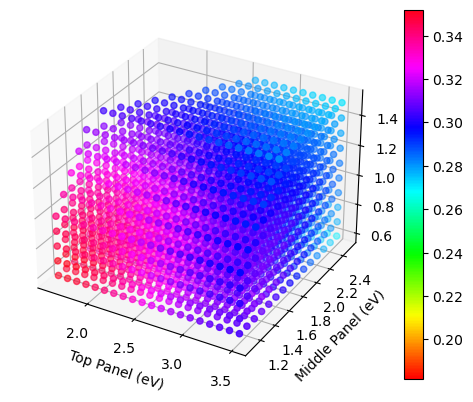

In [55]:

from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.mlab as ml
import scipy.interpolate
import matplotlib.cm as cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import pandas as pd









xi = outdf['cell 1']
yi = outdf['cell 2']
zi = outdf['cell 3']
ei = outdf['eff']


fig = plt.figure()

ax = fig.add_subplot(111,projection='3d')


colmap = cm.ScalarMappable(cmap=cm.hsv)
colmap.set_array(ei)


yg = ax.scatter(xi, yi, zi, c=cm.hsv(ei/max(ei)), marker='o')
cb = fig.colorbar(colmap)

ax.set_xlabel('Top Panel (eV)')
ax.set_ylabel('Middle Panel (eV)')
ax.set_zlabel('Lower Panel (eV)')


plt.show()